I've recently come across a new-to-me, and generally relatively recently developed, method of non-parametric regression called trend filtering. There is a paper by Tibshirani (2014) that establishes nice theoretical results, namely that trend filtering achieves a better minimax convergence rate to the true underlying function than traditional smoothing splines. It is also very fast to fit in the mean squared error regime, as I will show below.

# Underlying Function

As usual for these demos, we start by defining our true underlying function and take some noisy sample of it. Here, I'm borrowing the example given in Politsch et al. (2020) which is a function that has a smooth global trend with some intermittent "bumps" given by some radial basis functions:

$$
f(t) = 6 \sum_{k=1}^3 (t - 0.5)^k + 2.5 \sum_{j=1}^4 (-1)^j \phi_j(t)
$$

where the $\phi_j$ are given by the Gaussian RBF:

$$
\phi_j(x) = \exp \left( - \left( \epsilon \left( x - \psi \right) \right)^2 \right)
$$

where $\psi$ is the center point and $\epsilon$ is the bandwidth. Here we set $\psi=0.2, 0.4, 0.6, 0.8$ and $\epsilon=50$. We take the inputs as $t_i \sim \text{Uniform}(0, 1)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import cvxpy as cp
import scipy

rng = np.random.default_rng()

In [2]:
t_i = rng.uniform(0, 1, 500)
t_i.sort()

In [3]:
def rbf(x, center, epsilon):
    return np.exp(-((epsilon * (x - center)) ** 2))

In [4]:
rbfs = [partial(rbf, center=i, epsilon=50) for i in [0.2, 0.4, 0.6, 0.8]]


true_y = 6 * np.sum([(t_i - 0.5) ** k for k in [1, 2, 3]], axis=0) + 2.5 * np.sum(
    [(-1) ** j * rbfs[j - 1](t_i) for j in [1, 2, 3, 4]], axis=0
)
obs_y = true_y + rng.normal(0, 0.5**2, len(t_i))

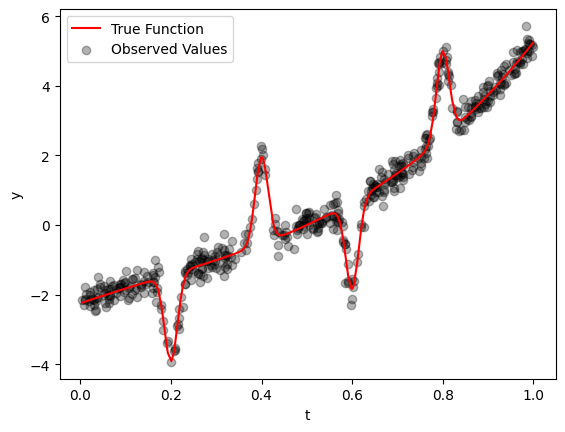

In [5]:
plt.plot(t_i, true_y, color="r")
plt.scatter(t_i, obs_y, alpha=0.3, color="black")
plt.xlabel("t")
plt.ylabel("y")
plt.legend(["True Function", "Observed Values"])

# Trend Filtering as a Basis Expansion

The first useful way to look at trend filtering is via a basis expansion perspective exactly like smoothing splines. Tibshirani prove that trend filtering has a basis function expansion given in equation (25), which I recreate here. Politsch et al. call this a *falling factorial* basis because of the iterated multiplicative form they take. Altering Tibshirani's notation slightly:

$$
j = 1, 2, \ldots, n \\
h_j(x) = x^{j-1} \quad \text{when} \quad j \leq k+1 \\
h_j(x) = \prod_{\ell=1}^k (x - x_{j-k-1+\ell}) * \mathbb{1}(x \ge x_{j-1}) \quad \text{when} \quad j \ge k+2
$$

where $n$ gives the total number of input points, and $k$ is the order of the trend filtering method. This number is related to the order of a smoothing spline in that it determines the degree of the piecewise polynomial that gets fitted to each segment of the input space. $k=0$ corresponds to a piecewise constant basis, $k=1$ to piecewise linear, and so on.

Python ranges generating sequences from 0 to $n-1$ so let's adjust our $j$ index to account for this:

$$
i = j - 1 = 0, 1, \ldots, n-1 \\
h_i(x) = x^i \quad \text{when} \quad i \le k \\
h_i(x) = \prod_{\ell=1}^k (x - x_{i-k+\ell}) * \mathbb{1}(x \ge x_{i}) = \prod_{\ell=0}^{k-1} (x - x_{i-k+\ell+1}) * \mathbb{1}(x \ge x_{i})\quad \text{when} \quad i \ge k+1
$$
However, Python lists are also zero-indexed so we need another adjustment on our subscripts to account for that too:
$$
h_i(x) = \prod_{\ell=0}^{k-1} (x - x_{i-k+\ell}) * \mathbb{1}(x \ge x_{i-1})\quad \text{when} \quad i \ge k+1
$$

In [6]:
def tf_basis(x, k, x_i):
    results = []
    n = len(x_i)
    for i in range(n):
        if i <= k:
            h = x**i
            results.append(h)
        elif i >= k + 1:
            h = 1
            for ell in range(k):
                h *= x - x_i[i - k + ell]
            h *= int(x >= x_i[i - 1])
            results.append(h)
    return results

Now, we can visualize this on some sample points. Here we set $k=2$, take our data to be $x_i=0, 0.2, 0.4, 0.6, 0.8, 1$, and plot the basis functions evaluated over the range $[0, 1]$:

Text(0.5, 1.0, 'k = 2')

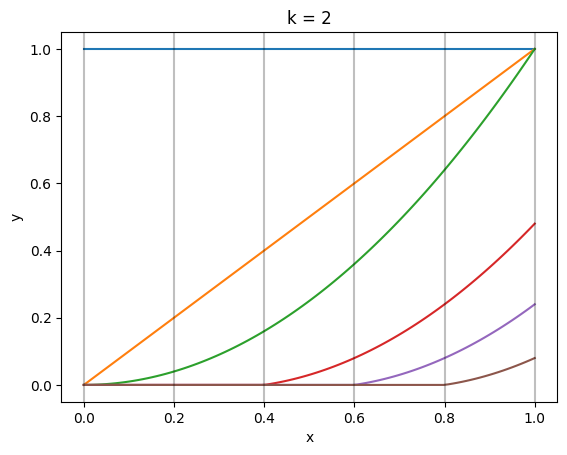

In [7]:
x_i = [0, 0.2, 0.4, 0.6, 0.8, 1]
xs = np.linspace(0, 1, 100)
test = np.array([tf_basis(x, 2, x_i) for x in xs])

for n in range(test.shape[1]):
    plt.plot(xs, test[:, n])

for x in x_i:
    plt.axvline(x, alpha=0.25, color="black")

plt.xlabel("x")
plt.ylabel("y")
plt.title("k = 2")

We can also see how changing $k$ changes the type of basis functions we get. Namely, if we set $k=0$ then we get a piecewise constant set of basis functions:

Text(0.5, 1.0, 'k = 0')

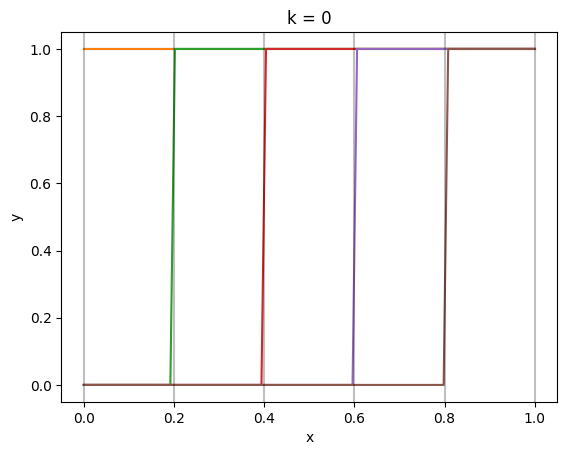

In [8]:
test = np.array([tf_basis(x, 0, x_i) for x in xs])

for n in range(test.shape[1]):
    plt.plot(xs, test[:, n])

for x in x_i:
    plt.axvline(x, alpha=0.25, color="black")

plt.xlabel("x")
plt.ylabel("y")
plt.title("k = 0")

# Fitting the Basis Function Approach

Now, we can express out model in the typical way as a function of the basis components:

$$
f(x) = \sum_{i=1}^n \alpha_i h_i(x)
$$

where $\alpha_i$ are our unknown coefficients. To fit this model we can form a design matrix where each row is the vector of the basis function outputs evaluated at the input point:

$$
\mathbf{X}_{i,j} = h_j(x_i) \quad \text{where} \quad i = 1, \ldots, n \quad j = 1, \ldots, n
$$

which gives us an $n \times n$ matrix. We can then form an $n \times 1$ coefficient vector and our regression becomes:

$$
y = \mathbf{X} \beta + \epsilon
$$

where if we assume that $\epsilon \sim \text{Normal}(0, \sigma^2)$ then we can use the standard least squares approach to find $\beta$. Note that because of the form of the basis expansion the first column of $\mathbf{X}$ will be all ones so we don't need to include a seperate intercept term.

We can also include an $\ell_1$ regularization term to our $\beta$ vector to promote sparsity, which gives us the objective function:

$$
\hat{\beta} = \argmin_\beta \frac{1}{2} \Vert{y - \mathbf{X}\beta} \Vert_2^2 + \lambda \Vert \beta \Vert_1
$$

Letting $k=1$ for a piecewise linear basis, and $\lambda = 0.01$, we can easily fit this model using cvxpy because our objective is convex:

In [38]:
k = 1
basis_eval = np.array([tf_basis(t, k, t_i) for t in t_i])
beta = cp.Variable(len(t_i))

objective = cp.Minimize(
    0.5 * cp.sum_squares(obs_y - basis_eval @ beta) + 0.01 * cp.norm(beta[k + 1 :], 1)
)
prob = cp.Problem(objective)
results = prob.solve(solver="CLARABEL", verbose=False)

Text(0.5, 1.0, 'k=1, lambda = 0.01')

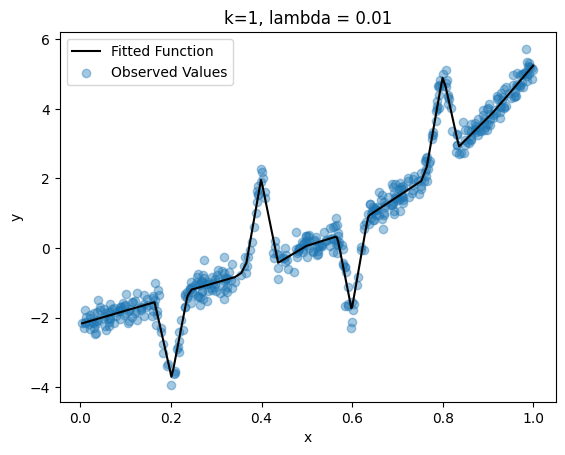

In [39]:
predict = basis_eval @ beta.value.round(2)
plt.plot(t_i, predict, color="black")
plt.scatter(t_i, obs_y, alpha=0.4)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Fitted Function", "Observed Values"])
plt.title("k=1, lambda = 0.01")

We can look at our fitted coefficients to see how many non-zero coefficients we get:

In [40]:
sum(np.abs(beta.value.round(2)) > 0)

33

We can also see what happens when we increase our regularization parameter to $\lambda=5$:

In [41]:
k = 1
basis_eval = np.array([tf_basis(t, k, t_i) for t in t_i])
beta = cp.Variable(len(t_i))

objective = cp.Minimize(
    0.5 * cp.sum_squares(obs_y - basis_eval @ beta) + 5 * cp.norm(beta[k + 1 :], 1)
)
prob = cp.Problem(objective)
results = prob.solve(solver="CLARABEL", verbose=False)

Text(0.5, 1.0, 'k=1, lambda = 5')

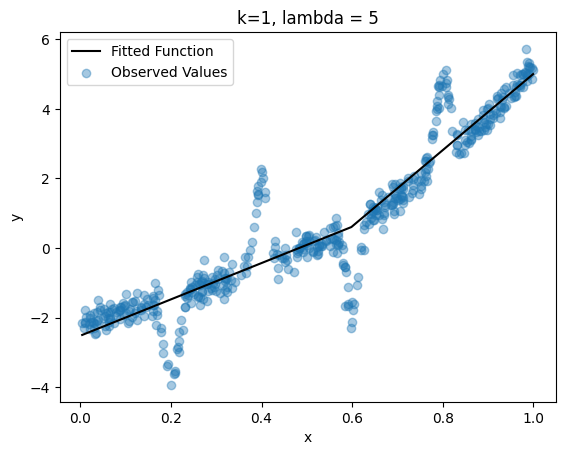

In [42]:
predict = basis_eval @ beta.value.round(2)
plt.plot(t_i, predict, color="black")
plt.scatter(t_i, obs_y, alpha=0.4)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Fitted Function", "Observed Values"])
plt.title("k=1, lambda = 5")

In [43]:
sum(np.abs(beta.value.round(2)) > 0)

3

We see a dramatically fewer number of non-zero coefficients, and we can also see one of the nice features of trend filtering: the "knots" of the basis functions are chosen automatically, in a sense. If we look at *where* the $\beta$ coefficients are non-zero:

In [44]:
np.where(np.abs(beta.value.round(2)) > 0)

(array([  0,   1, 281]),)

We can see that it's the first column, the intercept, and then another value along the domain of our input data. Essentially, the model has chosen to fit a piecewise linear function from the first value to this intermediate value, and another piecewise linear function over the rest of the domain. We can add the respective $x$-values of these points to our plot to see this:

Text(0.5, 1.0, 'k=1, lambda = 5')

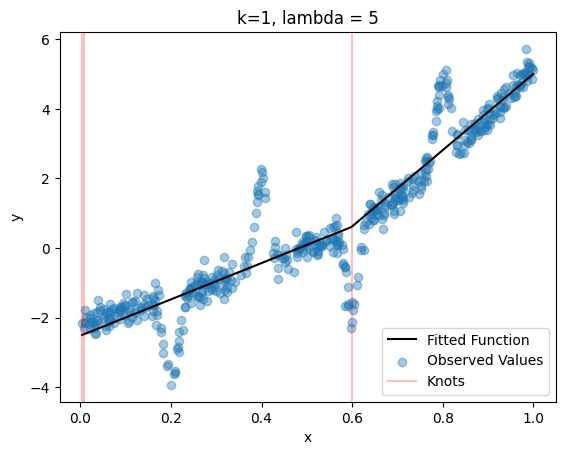

In [47]:
predict = basis_eval @ beta.value.round(2)
plt.plot(t_i, predict, color="black")
plt.scatter(t_i, obs_y, alpha=0.4)
for i in np.where(np.abs(beta.value).round(2) > 0)[0]:
    plt.axvline(t_i[i], color="red", alpha=0.25)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Fitted Function", "Observed Values", "Knots"])
plt.title("k=1, lambda = 5")

Where you can see that values where the $\beta$ coefficients are non-zero are the same places where the slope of the lines changes. As the regularization parameter gets smaller, more and more knot points are selected, creating more and more piecewise functions over different segments of the input domain. This is a huge plus for trend filtering compared to smoothing splines: the model selects the knot points automatically.

# Difference Operator Approach

Now, the basis function approach is easy to interpret and understand, but it is very computationally expensive because we have to evaluate every basis function at every point. The size of our design matrix scales with the square of the number of inputs, which is untenable for even moderately sized datasets.

Luckily, there is an easier way: we can still fit a unique parameter to each input data point, but we can adjust our regularization penalty so that it constrains *adjacent* coefficients to be the same as each other. As Tibshirani proves, this process is equivalent to the basis function approach, and, as we shall see, grants certain sparsity properties that make the model fitting process much faster.

The first key to this is the *difference operator matrix*. This is what defines our regularization constraint. Let's first look at the case where $k=0$. Here, we want to constrain the first difference of our coefficients:

$$
\sum_{i=1}^{n-1} \vert \beta_i - \beta_{i+1} \vert
$$

and we can achieve this by creating this matrix given by equation (3) in Tibshirani:

$$
D^{(1)} = \begin{bmatrix} -1 & 1 & 0 & \ldots & 0 & 0 \\
0 & -1 & 1 & \ldots & 0 & 0 \\
\vdots \\
0 & 0 & 0 & \ldots & -1 & 1
\end{bmatrix} \in \mathbb{R}^{(n-1) \times n}
$$

and then we can see that:

$$
\Vert D^{(1)} \beta \Vert_1 = \sum_{i=1}^{n-1} \vert \beta_i - \beta_{i+1} \vert
$$

Defining our constraint like this gives us a huge computational speedup because the $D$ matrix is *banded*, meaning only specific values along the diagonal are non-zero and the rest are all exactly zero. This means that smart optimization algorithms can ignore the computations where it knows that there is a multiplication by zero, which don't contribute anything to the objective value.

The first order difference matrix gives us the piecewise-constant basis, but you can construct higher order differences to get other bases for higher values of $k$. For instance, the second difference matrix when $k=1$ looks like this:

$$
D^{(2)} = \begin{bmatrix} 1 & -2 & 1 & 0 & \ldots & 0 & 0 \\
0 & 1 & -2 & 1 & \ldots & 0 & 0 \\
\vdots \\
0 & 0 & 0 & \ldots & 1 & -2 & 1
\end{bmatrix} \in \mathbb{R}^{(n-2) \times n}
$$

There is one additional subtlety: these matrices only work when we have evenly space inputs, which is very often not the case in practice. In the supplement to Tibshirani (2014), an adjustment to these difference matrices is provided to account for unevenly space inputs. First, note that we can define the above difference matrices recursively:

$$
D^{(k+1)} = \hat{D}^{(1)} \cdot D^{(k)}
$$

where $\hat{D}^{(1)}$ in this formula is the $(n-k-1) \times (n-k)$ version of the $D^{(1)}$ matrix we defined above. So, for instance, if $k=1$ then we have:

$$
D^{(k+1)} = D^{(2)} = \hat{D}^{(1)} \cdot D^{(1)}
$$

where $\hat{D}^{(1)}$ has dimensions $(n-2) \times (n-1)$ and $D^{(1)}$ has dimension $(n-1) \times (n)$ so in the end we get a matrix with dimension $(n-2) \times (n)$ which is the desired form.

Then, the adjustment for non-even spacing is given as:

$$
D^{(k+1)} = \hat{D}^{(1)} \cdot \text{diag} \left( \frac{k}{x_{k+1} - x_1}, \frac{k}{x_{k+2} - x_2}, \ldots, \frac{k}{x_n - x_{n-k}} \right) \cdot D^{(k)}
$$

So, in our case of $k=1$ we have:

$$
D^{(2)} = \hat{D}^{(1)} \cdot \text{diag} \left( \frac{k}{x_2 - x_1}, \frac{k}{x_3 - x_2}, \ldots, \frac{k}{x_n - x_{n-1}} \right) \cdot D^{(1)}
$$

Note that the case where $k=0$ requires no spacing adjustment.

We can make a nice recursive function that computes this matrix as follows:

In [48]:
def make_D_matrix(xs: np.ndarray, k: int, uneven: bool):
    n = xs.shape[0]
    ones = np.ones(n)
    if k == 0:
        return scipy.sparse.spdiags(
            np.vstack([-ones, ones]), range(2), m=n - k - 1, n=n
        )
    else:
        d_hat_1 = scipy.sparse.spdiags(
            np.vstack([-ones, ones]), range(2), m=n - k - 1, n=n - k
        )
        if uneven:
            return scipy.sparse.bsr_array(
                d_hat_1
                @ np.diag(1 / (t_i[k:] - t_i[:-k]))
                @ make_D_matrix(xs, k - 1, uneven)
            )
        else:
            return d_hat_1 @ make_D_matrix(xs, k - 1, uneven)

In [49]:
D = make_D_matrix(t_i, k=1, uneven=True)

We can then define our objective function as:

$$
\hat{\beta} = \argmin_\beta \frac{1}{2} \Vert y - \beta \Vert_2^2 + \lambda \Vert D^{(k+1)} \beta \Vert_1
$$

In [52]:
beta = cp.Variable(len(t_i))

objective = cp.Minimize(
    0.5 * cp.sum_squares(obs_y - beta) + 5 * cp.norm(D @ beta, 1)
)
prob = cp.Problem(objective)

results = prob.solve(solver="CLARABEL")

We can see that we recover the same piecewise linear solution as we did above, although with one fewer breakpoint and a slightly different value for the other, likely because of small numerical differences:

Text(0.5, 1.0, 'k=1, lambda = 5')

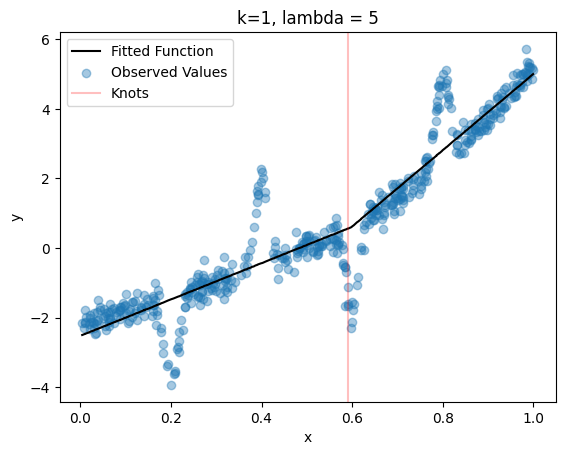

In [53]:
plt.plot(t_i, beta.value.round(2), color="black")
plt.scatter(t_i, obs_y, alpha=0.4)
for i in np.where(np.abs(D @ beta.value).round(2) > 0)[0]:
    plt.axvline(t_i[i], color="red", alpha=0.25)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Fitted Function", "Observed Values", "Knots"])
plt.title("k=1, lambda = 5")

In [54]:
np.where(np.abs(D @ beta.value).round(2) > 0)

(array([279]),)

We can also look at what a piecewise constant approach, with $k=0$, looks like:

In [55]:
# Note that the uneven parameter is redundant here
D = make_D_matrix(t_i, k=0, uneven=True)

In [56]:
beta = cp.Variable(len(t_i))

objective = cp.Minimize(
    0.5 * cp.sum_squares(obs_y - beta) + 5 * cp.norm(D @ beta, 1)
)
prob = cp.Problem(objective)

results = prob.solve(solver="CLARABEL")

We can see that maintaining the same $\lambda$ value gives us a function with many more degrees of freedom, but each segment is a constant value:

Text(0.5, 1.0, 'k=0, lambda = 5')

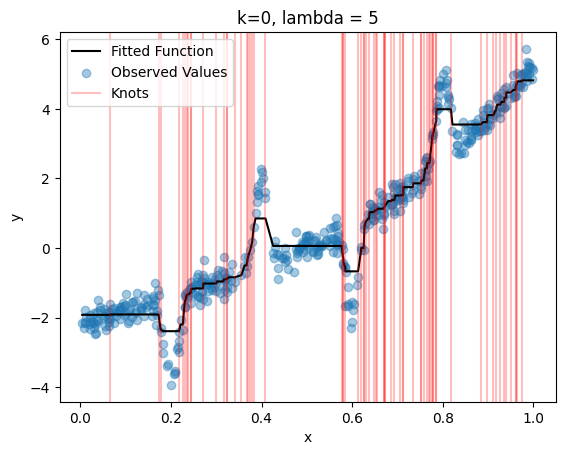

In [57]:
plt.plot(t_i, beta.value.round(2), color="black")
plt.scatter(t_i, obs_y, alpha=0.4)
for i in np.where(np.abs(D @ beta.value).round(2) > 0)[0]:
    plt.axvline(t_i[i], color="red", alpha=0.25)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Fitted Function", "Observed Values", "Knots"])
plt.title("k=0, lambda = 5")

# Final Notes

From my experimentation the difference matrix approach scales very well when you either have $k=0$ or evenly space inputs. If you have *unevenly* spaced inputs and set $k /ge 1$ then the optimization can fail depending on your regularization coefficient. This is because the scaling constants added in for the uneven spacing case can cause the result difference matrix to have quite large values. You can see this from the terms, where each is the multiplicative inverse of the difference between consecutive observed $x$ values. In cases where the difference is small, these values end up being large, which causes numerical instability when doing the optimization.

However, sticking to the evenly-spaced case, or the piecewise constant case, results in optimizations that can be solved on the order of seconds even for more than 100,000 input points. Given this is a non-parametric approach the computational scaling is surprisingly nice, especially since I'm using an off-the-shelf optimizer. Tibshirani and some other authors have implemented custom optimization procedures that could very well outperform what I'm doing here.

All-in-all I find this method to be theoretically quite appealing, from the minimax convergence properties to the "automatic" knot selection. Add to this an acceptable computational scaling, and this seems very promising to me, and I find it surprising that I'm just now hearing about it. Admittedly, there are a number of practical implementation issues I can see:
- Doing out-of-sample predictions, whether new values inside of the training domain, or for values outside of it
- Handling real data where we have possibly many observations for a single given $x$ value
- Extension to the multivariate case
- Moving from MSE loss to the general maximum likelihood case

Luckily, I think these are all issues that can be taken care of with enough clever software engineering. 

# References

Ryan J. Tibshirani. "Adaptive piecewise polynomial estimation via trend filtering." The Annals of Statistics,
42(1) 285-323 February 2014. [https://doi.org/10.1214/13-AOS1189](https://doi.org/10.1214/13-AOS1189)

Collin A Politsch, Jessi Cisewski-Kehe, Rupert A C Croft, Larry Wasserman, Trend filtering – I. A modern statistical tool for time-domain astronomy and astronomical spectroscopy, Monthly Notices of the Royal Astronomical Society, Volume 492, Issue 3, March 2020, Pages 4005–4018, https://doi.org/10.1093/mnras/staa106